In [1]:
import pandas as pd
import scipy.io
import scipy.signal as ss
import pywt
import glob
import matplotlib.pyplot as plt
import scaleogram as scg
from scaleogram import cws
import numpy as np
from math import *
import os

In [2]:
print(os.getcwd())
os.chdir("..")

E:\git\HeartResearch\Data Preprocessing


In [3]:
main_data_dir = os.getcwd() + "\Data set"
print(os.listdir(main_data_dir))

['.ipynb_checkpoints', 'Gaussian_Filter', 'Label.csv', 'Median_Filter', 'Output', 'Output.png', 'README.md', 'Scaleogram_512_256', 'Segmentation', 'Segment_filter_label', 'TrainingSet1', 'TrainingSet2', 'TrainingSet3']


In [4]:
data_mat_files = glob.glob(main_data_dir + "/TrainingSet*/*")
label_path = main_data_dir + "/Label.csv"
label_df = pd.read_csv(label_path)

In [5]:
label_df

Recording  First_label  Second_label  Third_label
0        A0001            5           NaN          NaN
1        A0002            1           NaN          NaN
2        A0003            2           NaN          NaN
3        A0004            2           NaN          NaN
4        A0005            7           NaN          NaN
...        ...          ...           ...          ...
6872     A6873            3           NaN          NaN
6873     A6874            8           NaN          NaN
6874     A6875            4           NaN          NaN
6875     A6876            2           NaN          NaN
6876     A6877            7           NaN          NaN

[6877 rows x 4 columns]

In [6]:
label_df.drop(['Second_label', 'Third_label'], axis=1)

Recording  First_label
0        A0001            5
1        A0002            1
2        A0003            2
3        A0004            2
4        A0005            7
...        ...          ...
6872     A6873            3
6873     A6874            8
6874     A6875            4
6875     A6876            2
6876     A6877            7

[6877 rows x 2 columns]

In [7]:
label = label_df['First_label'].tolist()

In [8]:
def data_extract(signal_raw_list, start_point):
    signal_list = []
    signal_number_list = []
    
    for signal in signal_raw_list:
        mat = scipy.io.loadmat(signal)
        signal_list.append(mat['ECG'][0][0][2][:,start_point:])
        signal_number = signal.split('\\')[-1].split('.')[0]
        signal_number_list.append(signal_number)

    return (signal_list, signal_number_list)

signal_list, signal_number = data_extract(data_mat_files, 300)

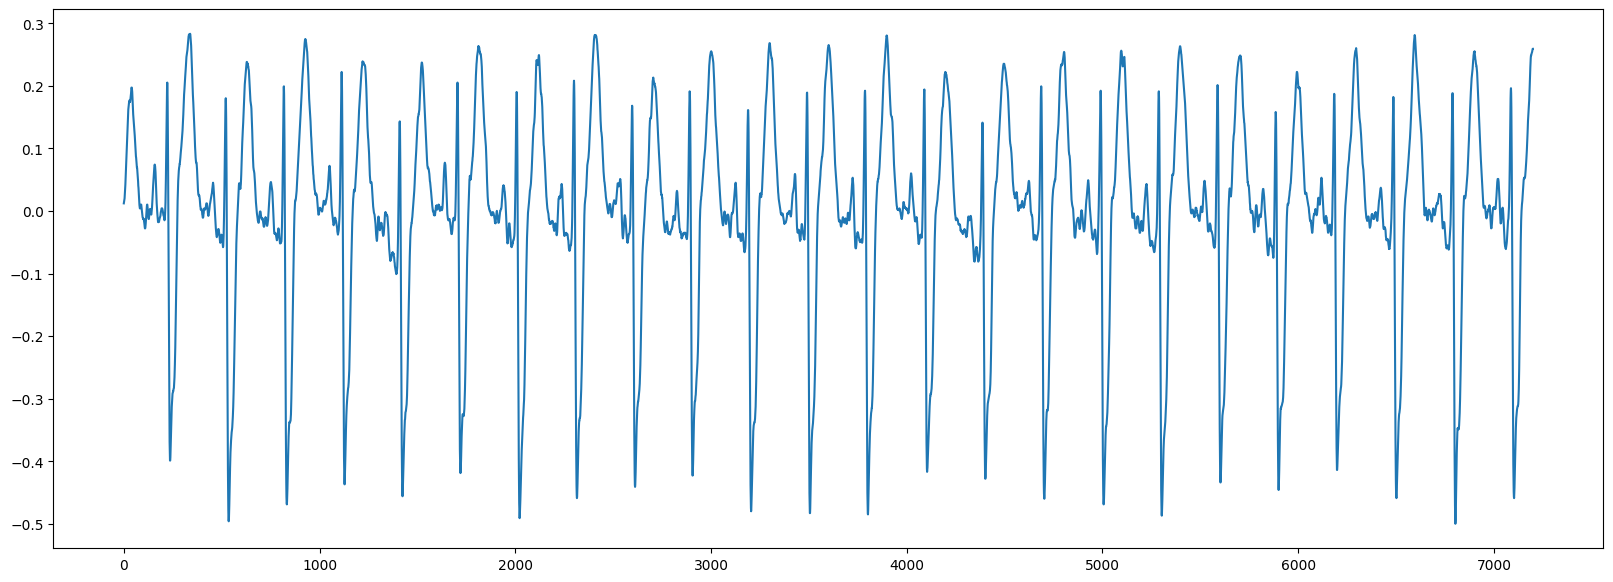

In [9]:
plt.figure(figsize=(20,7))
plt.plot(signal_list[0][0])

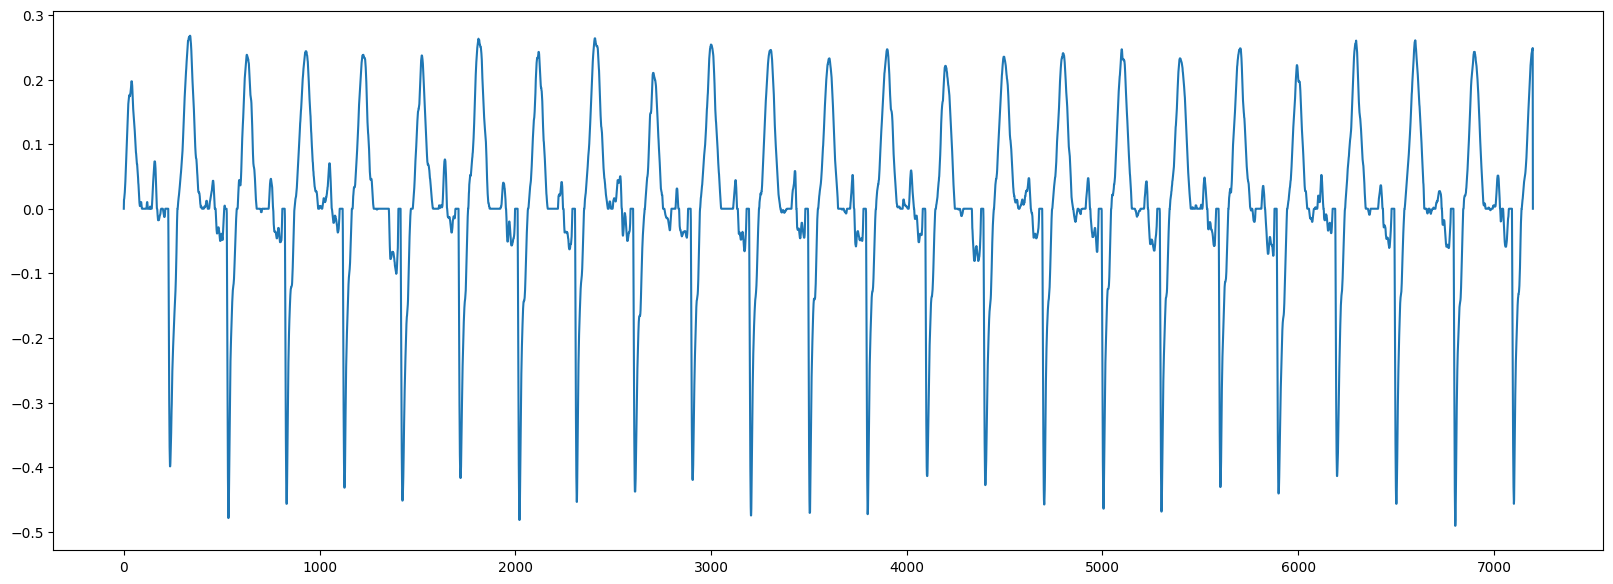

In [10]:
med1 = ss.medfilt(signal_list[0])
plt.figure(figsize=(20,7))
plt.plot(med1[0])

<class 'numpy.ndarray'>
[0.0122288 0.0142288 0.0152288 ... 0.2502288 0.2502288 0.2502288]
7200


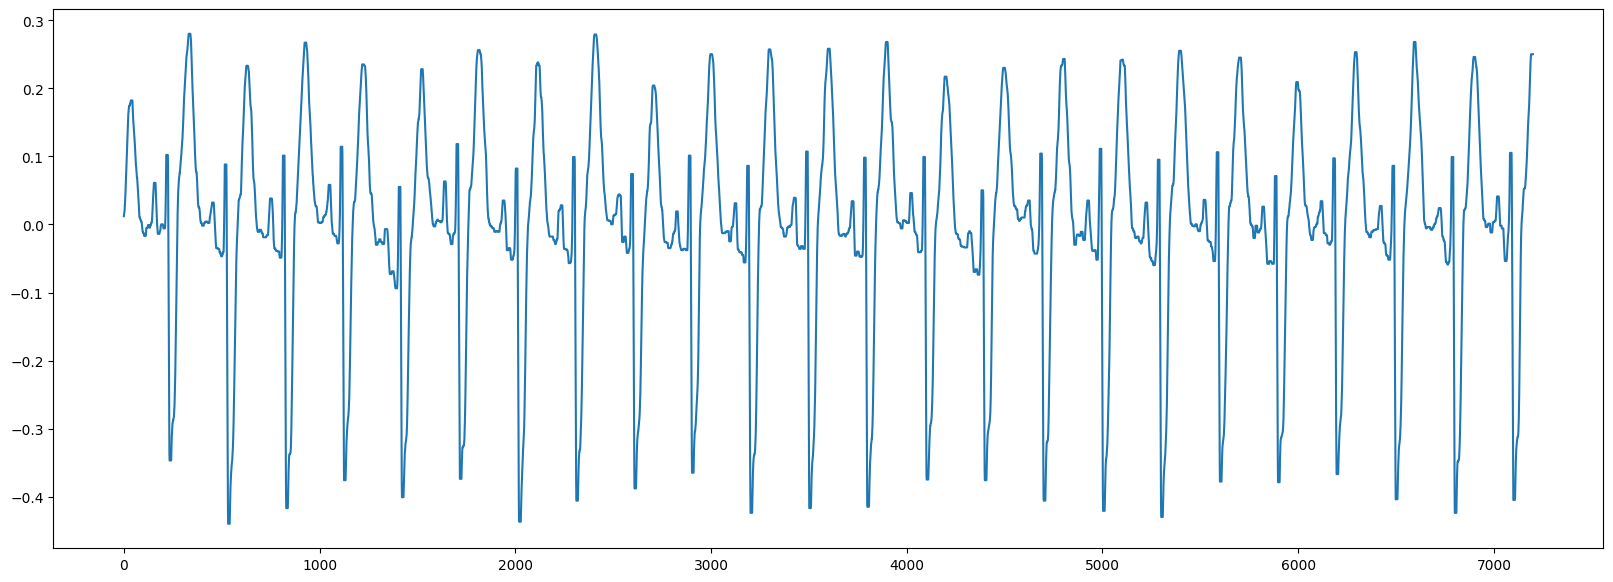

In [11]:
med2 = ss.medfilt(signal_list[0][0], 17)
print(type(med2))
print(med2)
print(len(med2))
plt.figure(figsize=(20,7))
plt.plot(med2)

In [11]:
def median_filter(signal_raw_list):
    median_fil_list = []

    for i in range(len(signal_raw_list)):
        for j in range(12):
            median_fil = ss.medfilt(signal_raw_list[i][j])
            median_fil_list.append(median_fil)    
    return median_fil_list
    
median_fil_list = median_filter(signal_list)

In [13]:
len(median_fil_list)

82524

In [14]:
len(median_fil_list[11])

7200

In [16]:
median_fil_list[:5]

[array([0.0122288, 0.0142288, 0.0152288, ..., 0.2582288, 0.2592288,
        0.2592288]),
 array([0.07172947, 0.07572947, 0.07972947, ..., 0.24772947, 0.24872947,
        0.24872947]),
 array([ 0.05950067,  0.06150067,  0.06450067, ..., -0.01049933,
        -0.01049933, -0.00949933]),
 array([-0.04149067, -0.04449067, -0.04749067, ..., -0.25249067,
        -0.25449067, -0.25449067]),
 array([-0.0226448, -0.0226448, -0.0246448, ...,  0.1343552,  0.1343552,
         0.1343552])]

In [23]:
segment_file_name = "{}_lead{}_seg{}.mat"
# segment_name_list = []
# label_list = []

def segmentation_and_filter_scaleogram(signal_filt_list, seg_len, folder):
    output_path = main_data_dir + "\Scaleogram_512_256\{}_{}_lead{}_seg{}"
    scg.set_default_wavelet('morl')
    px = 1/plt.rcParams['figure.dpi']
    lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
    count = 0
    
    for i in range(len(signal_filt_list)):
        sig_len = len(signal_filt_list[i])
        seg_num = ceil(sig_len/seg_len)
#         segment_list = []
        for w in range(1,seg_num+1):
            x = floor((sig_len-seg_len)/(seg_num-1)*(w-1))
            segment = signal_filt_list[i][x:x+1600]
#             segment_list.append(segment)
            save_dic_data = {"ECG_segment": segment}
#             label_list.append(label[floor(i/12)])
#             segment_name_list.append(segment_file_name.format(signal_number[floor(i/12)], count+1, w))
            scipy.io.savemat(main_data_dir + "\Segmentation\{}_lead{}_seg{}.mat".format(signal_number[floor(i/12)], count+1, w), save_dic_data)
            
#             scales = scg.periods2scales(np.arange(1, seg_len+1)) # change scale here
#             x_values_wvt_arr = range(0,sig_len,1)
#             for segment in segment_list:
#                 fig = cws(segment, scales=scales, figsize=(512*px, 256*px), coi = False)
# #           print(fig)
#                 plt.axis('off')
#                 plt.savefig(output_path.format(folder, signal_number[floor(i/12)],count+1, w), bbox_inches='tight', pad_inches = 0)
            fig, ax = cws(segment, 
                          scales=scg.periods2scales(np.arange(1, 500)), # oh exactly 
                          figsize=(512*px, 256*px), coi = False)
            plt.axis('off')
            plt.savefig(output_path.format(folder, signal_number[floor(i/12)],count+1, w), bbox_inches='tight', pad_inches = 0)
            fig.clear()
            plt.close(fig)
            ax.clear()
            plt.cla()
            plt.close("all")
            
        
        if count == 11:
            count = 0
        else:
            count += 1
#     seg_label_df = pd.DataFrame(list(zip(segment_name_list, label_list)), columns = ['Segment', 'Label'])  
    
#     return segment_list

In [24]:
segmentation_and_filter_scaleogram(median_fil_list[:1], 1600, folder = 'Median_Filter')

In [42]:
segment_list, seg_label_df = segmentation_and_filter_scaleogram(median_fil_list[:30], 1600, folder = 'Median_Filter')

In [43]:
seg_label_df.to_csv(main_data_dir + "\Segment_filter_label\Segment_Median_label.csv")

In [49]:
segment_file_name = "{}_lead{}_seg{}.mat"
segment_list = []
segment_name_list = []
label_list = []

def segmentation_and_filter_scaleogram1(signal_filt_list, seg_len, folder):
    output_path = main_data_dir + "\Scaleogram_512_256\{}\{}_{}_lead{}_seg{}"
    scg.set_default_wavelet('morl')
    px = 1/plt.rcParams['figure.dpi']
    lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
    count = 0
    
    for i in range(len(signal_filt_list)):
        sig_len = len(signal_filt_list[i])
        seg_num = ceil(sig_len/seg_len)
        for w in range(1,seg_num+1):
            x = floor((sig_len-seg_len)/(seg_num-1)*(w-1))
            segment = signal_filt_list[i][x:x+1600]
            segment_list.append(segment)
            save_dic_data = {"ECG_segment": segment}
            label_list.append(label[floor(i/12)])
            segment_name_list.append(segment_file_name.format(signal_number[floor(i/12)], count+1, w))
#             scipy.io.savemat(main_data_dir + "\Segmentation\{}_lead{}_seg{}.mat".format(signal_number[floor(i/12)], count+1, w), save_dic_data)
            
            scales = scg.periods2scales(np.arange(1, seg_len+1))
            x_values_wvt_arr = range(0,sig_len,1)
            for segment in segment_list:
                fig = cws(segment, scales=scales, figsize=(512*px, 256*px), coi = False)
#           print(fig)
                plt.axis('off')
                plt.savefig(output_path.format(folder, folder, signal_number[floor(i/12)],count+1, w), bbox_inches='tight', pad_inches = 0)
        
        if count == 11:
            count = 0
        else:
            count += 1
    seg_label_df = pd.DataFrame(list(zip(segment_name_list, label_list)), columns = ['Segment', 'Label'])  
    
    return segment_list, seg_label_df

([array([0.0122288, 0.0142288, 0.0152288, ..., 0.0082288, 0.0082288,
         0.0052288]),
  array([-0.0607712, -0.0427712, -0.0217712, ...,  0.2502288,  0.2502288,
          0.2532288]),
  array([-0.0277712, -0.0277712, -0.0247712, ..., -0.3207712, -0.3617712,
         -0.3927712]),
  array([ 0.2202288,  0.2182288,  0.2172288, ..., -0.0237712, -0.0207712,
         -0.0157712]),
  array([-0.3877712, -0.4137712, -0.4307712, ...,  0.2582288,  0.2592288,
          0.2592288])],
                 Segment  Label
 0  A0001_lead1_seg1.mat      5
 1  A0001_lead1_seg2.mat      5
 2  A0001_lead1_seg3.mat      5
 3  A0001_lead1_seg4.mat      5
 4  A0001_lead1_seg5.mat      5)

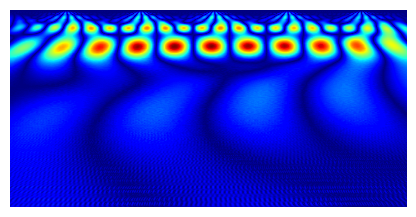

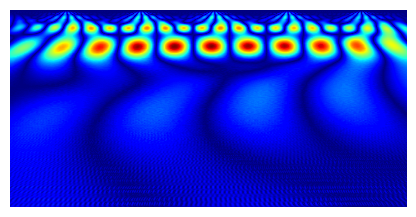

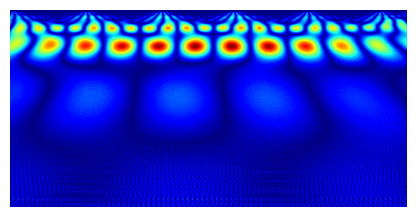

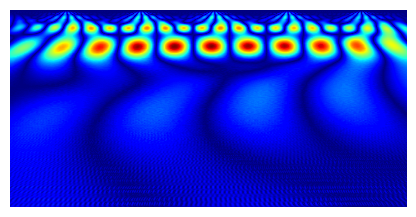

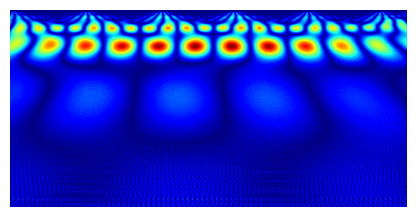

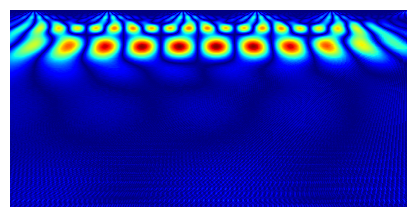

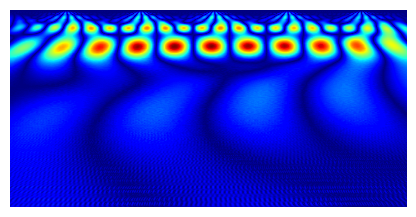

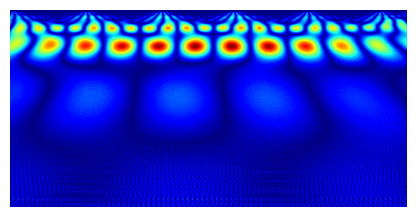

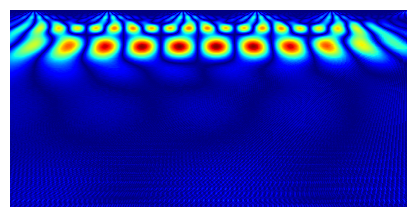

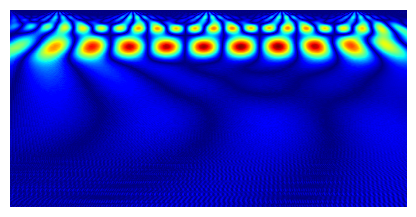

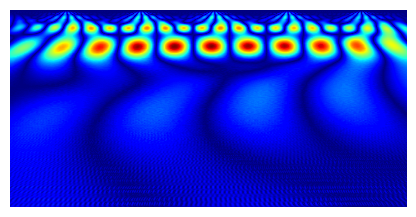

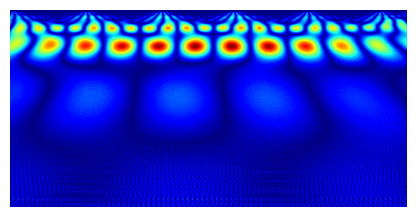

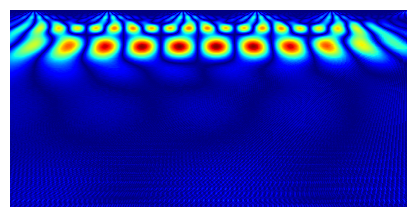

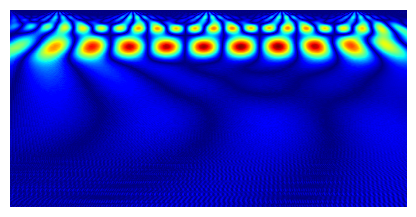

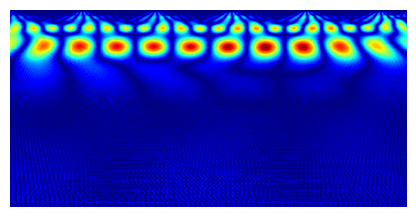

In [50]:
segmentation_and_filter_scaleogram1(median_fil_list[:1], 1600, folder = 'Median_Filter')

In [ ]:
# LINH 3/1
output_path = main_data_dir + "\Scaleogram_512_256\{}_{}_{}"
scg.set_default_wavelet('morl')
px = 1/plt.rcParams['figure.dpi']
lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

def scaleogram(data, folder):
    count = 0
    for i in range(len(data)):
            signal_length = 1600
            # range of scales to perform the transform
            scales = scg.periods2scales(np.arange(1, signal_length+1))
            x_values_wvt_arr = range(0,len(data[i]),1)

            # plot the signal 
#             fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
#             ax1.plot(x_values_wvt_arr, data[i][j], linewidth=3, color='blue')
#             ax1.set_xlim(0, signal_length)
#             ax1.set_title("ECG")

            # the scaleogram
            fig = cws(data[i][:signal_length], scales=scales, figsize=(512*px, 256*px), coi = False)
#             print(fig)
            plt.axis('off')
            plt.savefig(output_path.format(folder, signal_number[i],lead[j]), bbox_inches='tight', pad_inches = 0)

In [ ]:
scaleogram(segment_list, folder = "Median_Filter")

In [35]:
segment_file_name = "{}_lead{}_seg{}.mat"
# segment_list = []
segment_name_list = []
label_list = []

def segmentation(signal_list, seg_len):
    for i in range(len(signal_list)):
        for j in range(12):
            sig_len = len(signal_list[i][j])
            seg_num = ceil(sig_len/seg_len)
            for w in range(1,seg_num+1):
                x = floor((sig_len-seg_len)/(seg_num-1)*(w-1))
                segment = signal_list[i][j][x:x+1600]
                save_dic_data = {"ECG_segment": segment}
#                 segment_list.append(segment)
                label_list.append(label[i])
                segment_name_list.append(segment_file_name.format(signal_number[i], j+1, w))
#                 scipy.io.savemat(main_data_dir + "\Segmentation\{}_lead{}_seg{}.mat".format(signal_number[i], j+1, w), save_dic_data)
    seg_label_df = pd.DataFrame(list(zip(segment_name_list, label_list)), columns = ['Segment', 'Label'])  
    return seg_label_df

In [36]:
# seg_label_df = segmentation(signal_list,1600)

In [37]:
# seg_label_df.to_csv(main_data_dir + "\Segment_label.csv")

In [22]:
def save_data_filter(data, signal_number, folder):
    for i in range(len(data)):
        save_dic_data = {"ECG": data[i]}
        scipy.io.savemat("E:\git\HeartResearch\Data set\{}\{}.mat".format(folder,signal_number[i]), save_dic_data)

In [8]:
save_data_filter(median_fil_list, signal_number, folder = "Median_Filter")

In [10]:
output_path = main_data_dir + "\Scaleogram_512_256\{}_{}_{}"
scg.set_default_wavelet('morl')
px = 1/plt.rcParams['figure.dpi']
lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

def scaleogram(data, folder, signal_length):
    for i in range(len(data)):
        for j in range(len(lead)):
            
#             signal_length = 1600
            # range of scales to perform the transform
            scales = scg.periods2scales(np.arange(1, signal_length+1))
            x_values_wvt_arr = range(0,len(data[i][j]),1)

            # plot the signal 
            fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
            ax1.plot(x_values_wvt_arr, data[i][j], linewidth=3, color='blue')
            ax1.set_xlim(0, signal_length)
            ax1.set_title("ECG")

            # the scaleogram
            fig = cws(data[i][j][:signal_length], scales=scales, figsize=(512*px, 256*px), coi = False)
            print(fig)
            plt.axis('off')
#             plt.savefig(output_path.format(folder, signal_number[i],lead[j]), bbox_inches='tight', pad_inches = 0)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_81032\964922597.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));


AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


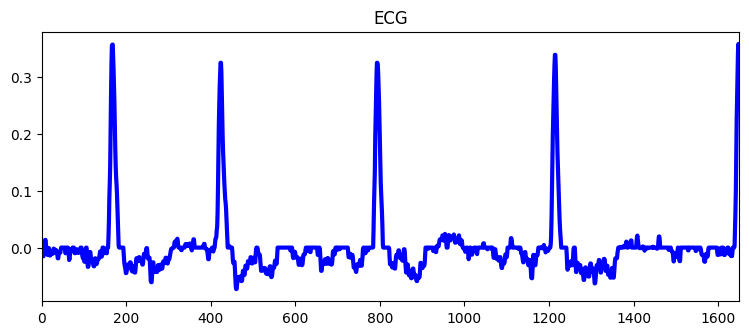

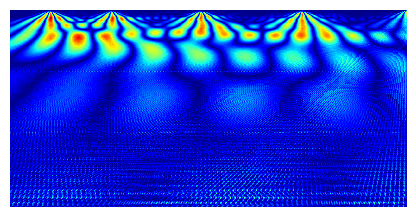

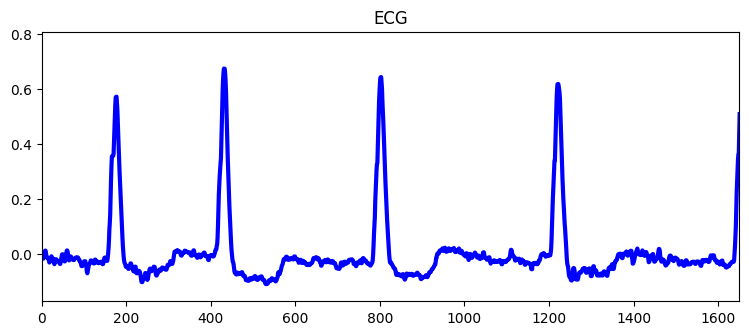

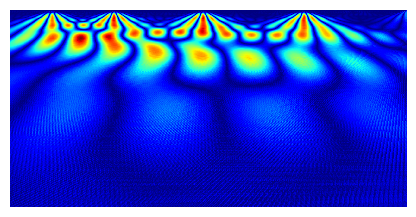

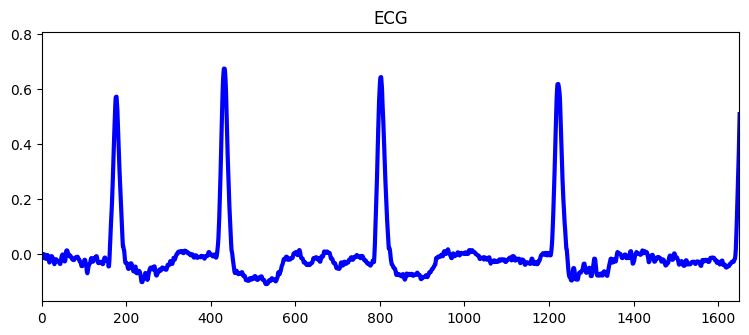

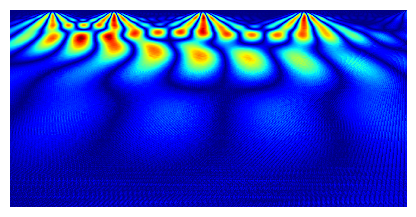

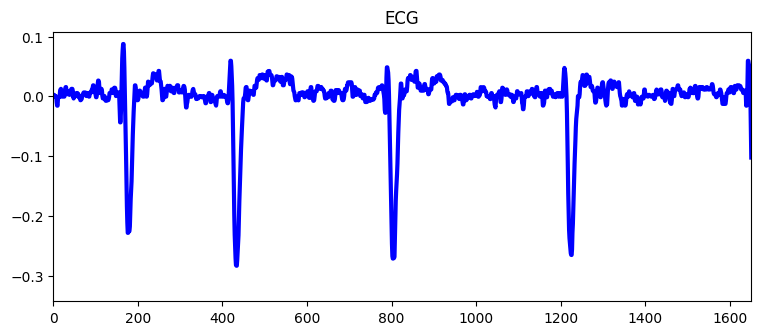

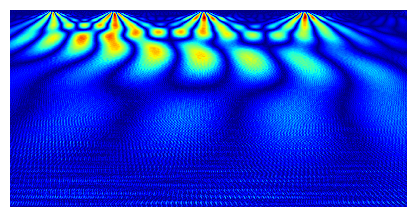

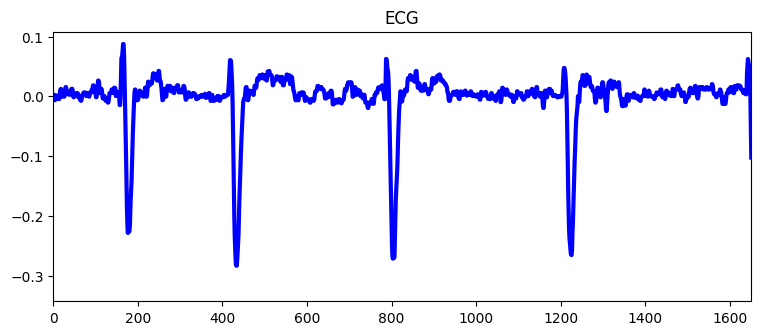

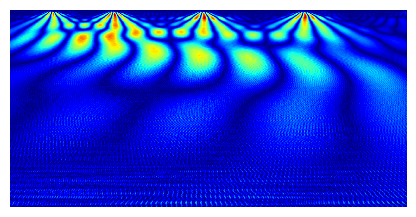

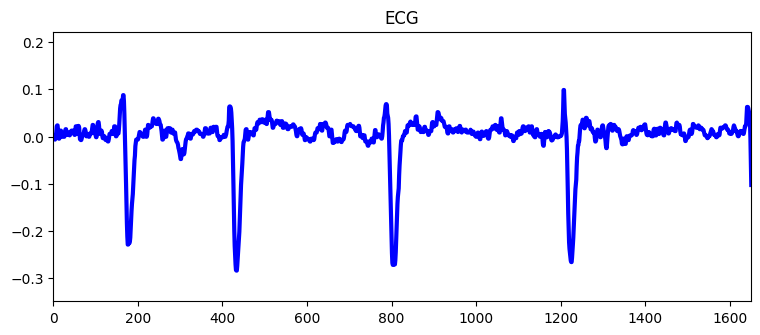

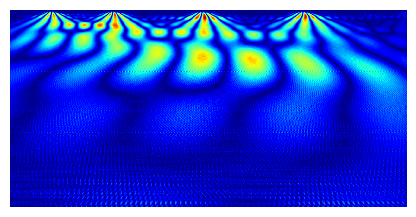

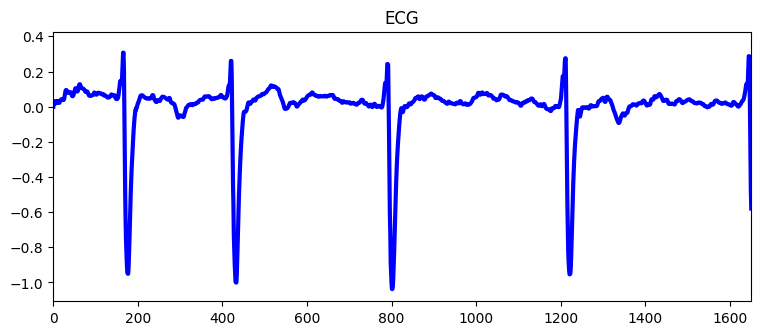

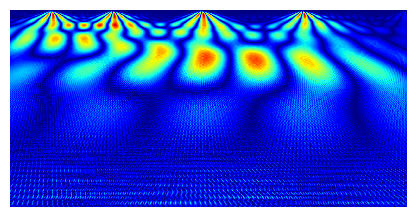

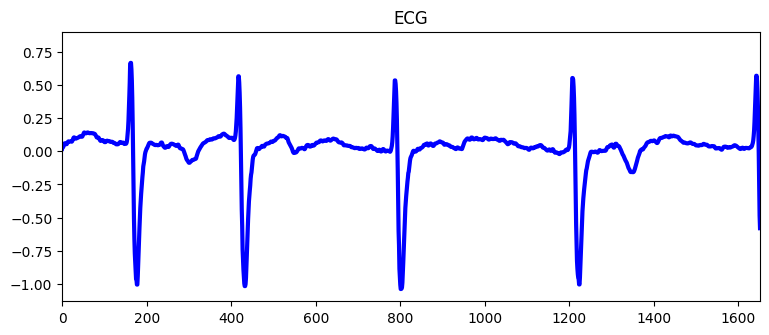

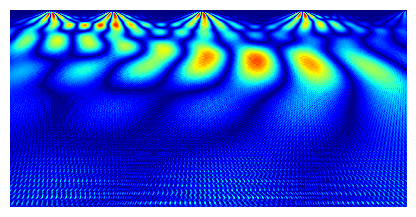

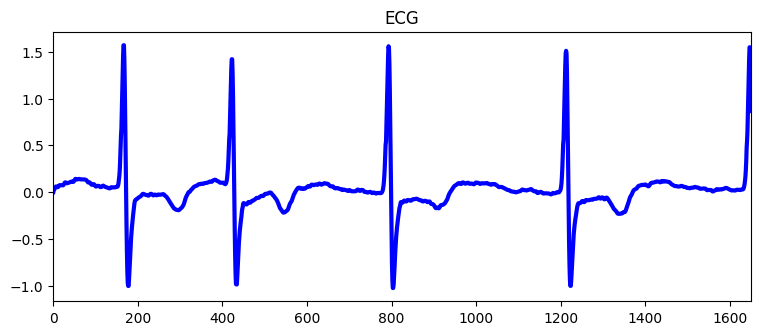

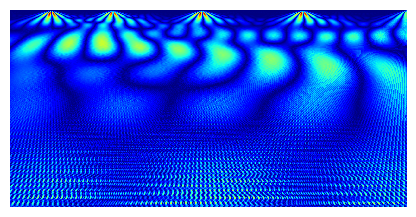

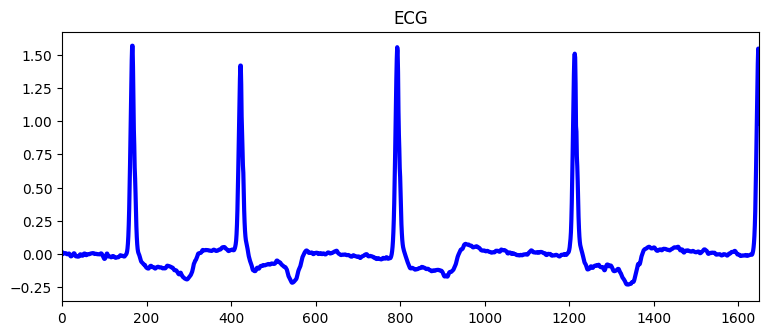

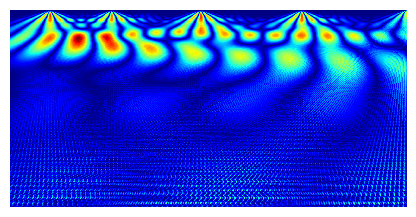

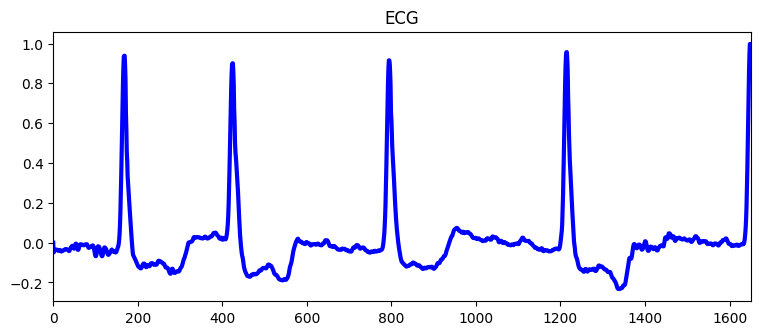

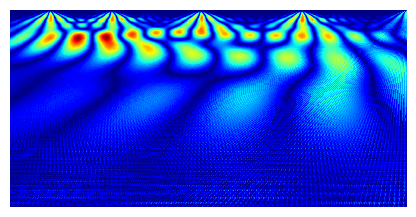

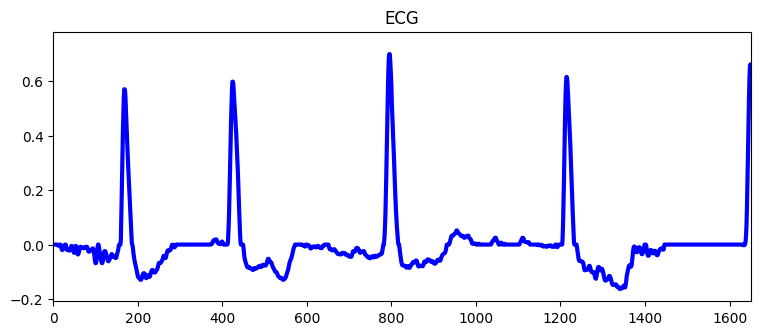

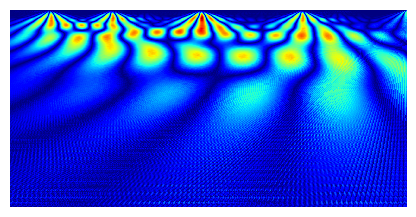

In [19]:
scaleogram(median_fil_list[60:61], folder = "Median_Filter", signal_length=1650)

In [7]:
def gaussian_filter(signal_raw_list, std):
    gauss_filt = []
    n_bins = signal_raw_list.shape[2]
    M = n_bins - 1 if n_bins % 2 == 0 else n_bins
    window = ss.gaussian(M, std = std)

    for signal in signal_raw_list:
        for i in range(signal.shape[0]):
            gauss_filter = ss.convolve(signal[i], window, mode='same', method='auto')
            gauss_filt.append(gauss_filter)    
    return gauss_filt

In [8]:
gauss_filt = gaussian_filter(signal_list, std=1)

In [17]:
gauss_filt_array = (np.array(gauss_filt)).reshape(6877,12,3000)
gauss_filt_list = []
for i in range(gauss_filt_array.shape[0]):
    gauss_filt_list.append(gauss_filt_array[i])

In [23]:
folder = "Gaussian_Filter"
save_data_filter(gauss_filt_list, signal_number, folder)

In [42]:
(np.array(signal_list).shape

SyntaxError: invalid syntax (613659903.py, line 1)

[-0.0226448 -0.0226448 -0.0246448 ...  0.1343552  0.1343552  0.1343552]
<class 'numpy.ndarray'>


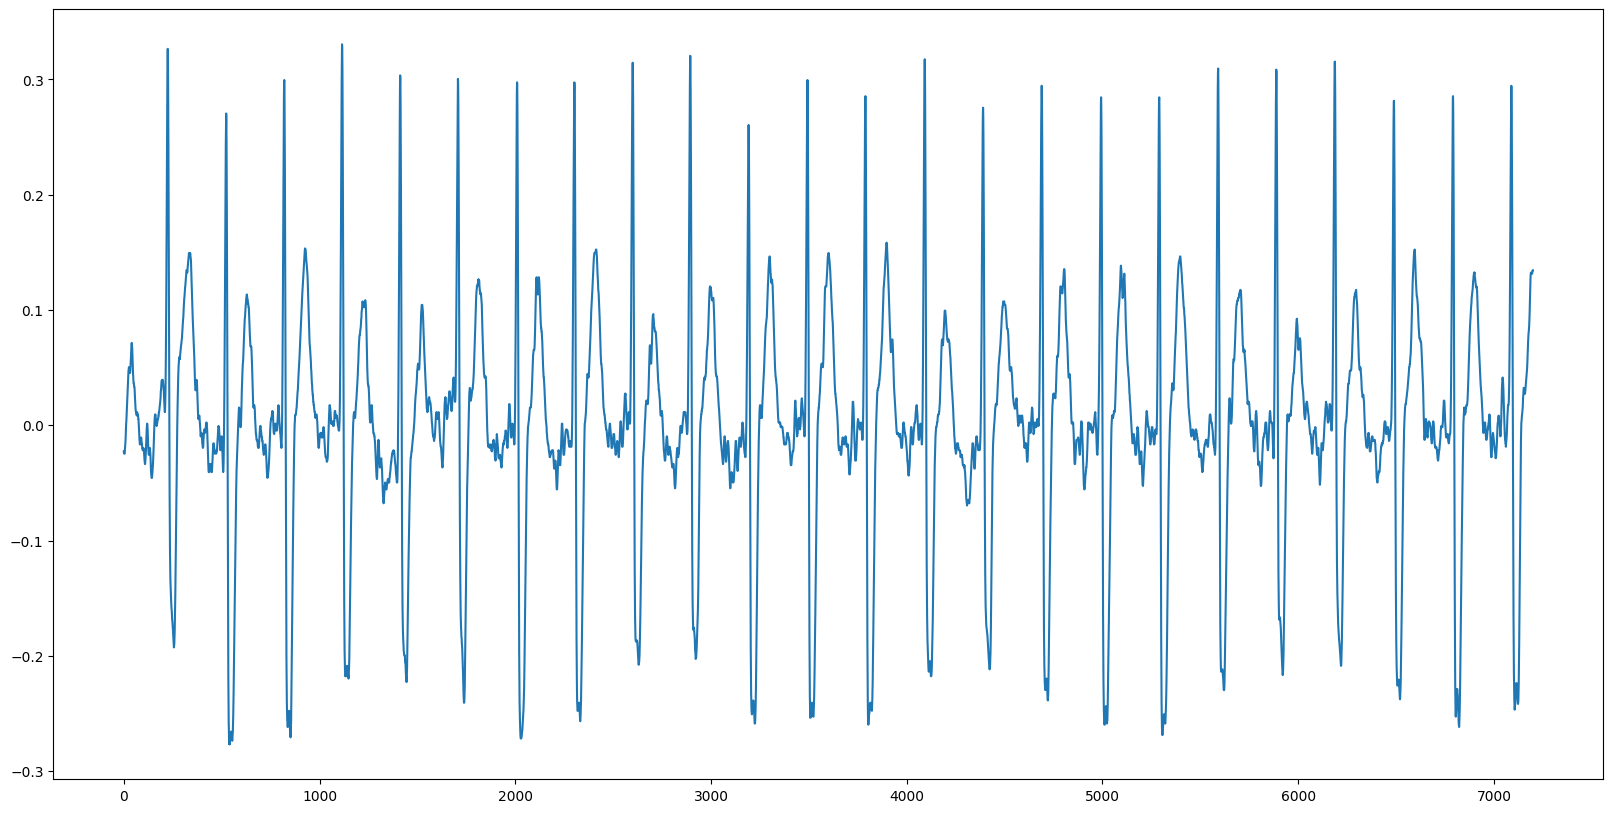

In [35]:
plt.figure(figsize=(20,10))
plt.plot(signal_list[0][4])
print(signal_list[0][4])
print(type(signal_list[0][4]))

[-0.0156448 -0.0156448 -0.0156448 ...  0.1313552  0.1313552  0.1313552]


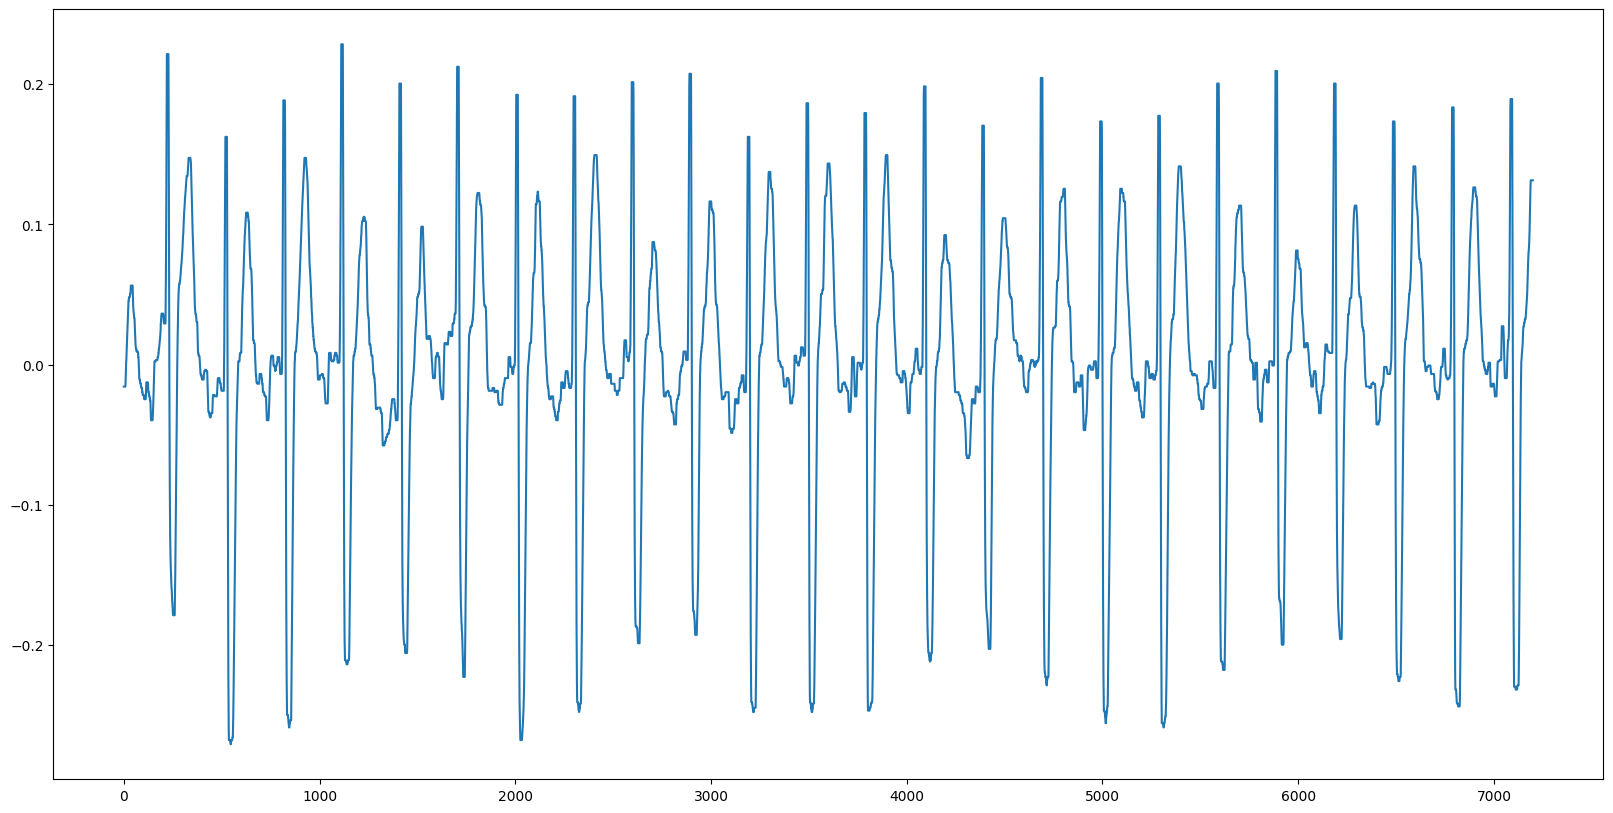

In [31]:
plt.figure(figsize=(20,10))
y = ss.medfilt(signal_list[0][4], 17)
plt.plot(y)
print(y)